## Exploratory Data Analysis

We first take a look at our data. We check the balance of our classes before we start any of the classification task. Also, since we have images of both eyes per patient, we can check if diabetic retinopathy is more prevalent in either eye in our dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from scipy import misc
from skimage import color
import glob
import seaborn as sns
import pandas as pd
import os
sns.set(style="white", palette="muted", color_codes=True)

In [2]:
labelpath = '/home/aremirata/thesis/kaggle/trainLabels.csv'
df_labels = pd.read_csv(labelpath)

In [3]:
df_labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
Counter(df_labels.level)

Counter({0: 25810, 1: 2443, 2: 5292, 3: 873, 4: 708})

In [5]:
frequency = df_labels.level.value_counts()/len(df_labels)

In [6]:
frequency

0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: level, dtype: float64

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


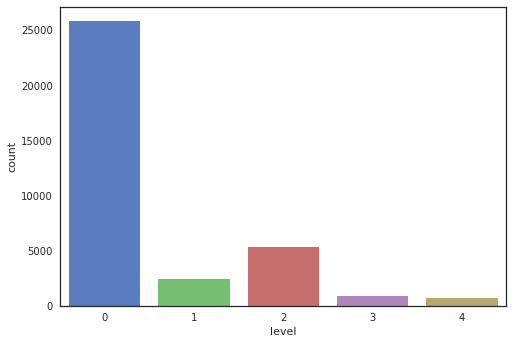

In [7]:
sns.countplot(df_labels['level'])

The levels of Retinopathy in this dataset are:

$
0 - \text{No DR} \\
1 - \text{Mild} \\
2 - \text{Moderate} \\
3 - \text{Severe} \\
4 - \text{Proliferative DR} \\
$

Clearly, we have many more instances of normal eyes than eyes with retinopathy in our training set. Oddly class 2 retinopathy is more common than the other levels of severity. Kaggle claims these images were rated by clinicians in varying settings. Perhaps clinicians are avoiding giving out Mild or Severe ratings for some reason?


We check if retinopathy is more prevalent in left or right eye.

In [8]:
df_labels['location'] = df_labels['image'].apply(lambda s: 'left' if 'left' in s.lower() else 'right') 

In [9]:
df_labels.head()

,image,level,location
0,10_left,0,left
1,10_right,0,right
2,13_left,0,left
3,13_right,0,right
4,15_left,1,left


/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


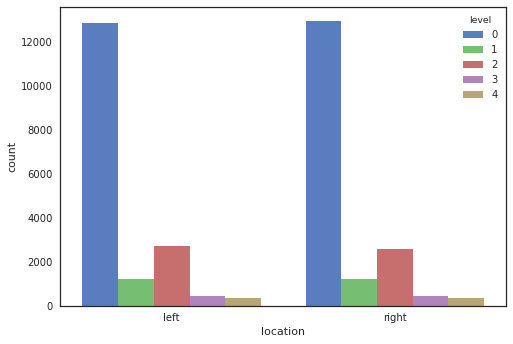

In [10]:
sns.countplot(x="location", hue="level", data=df_labels[['level', 'location']])
plt.show()

It seems that if you have diabetic retinopathy on one eye, you're more likely to have it on the other. Just a sanity check, we find how many datapoints belong to left or right eye.

In [11]:
Counter(df_labels.location)

Counter({'left': 17563, 'right': 17563})

# Examine the Training Images

In [12]:
training_images = glob.glob('/home/aremirata/thesis/kaggle/train/*')

In [13]:
eye0 = misc.imread(training_images[0])

In [14]:
eye0.shape

(2048, 3072, 3)

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


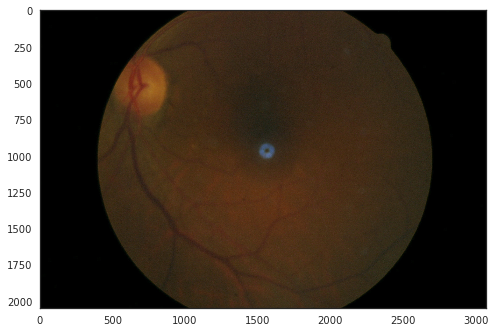

In [15]:
plt.imshow(eye0)

In [16]:
training_images[0].split('/')[-1]

'32734_left.jpeg'

In [17]:
df_labels[df_labels['image'] == '32734_left']

,image,level,location
25868,32734_left,0,left


In [18]:
df_labels['image'][0]

'10_left'

## Determine the Size of the Images

In [19]:
index = range(0, len(training_images))
df_info = pd.DataFrame(index=index, columns=['image','shape'])
for i in range(len(training_images)):
    df_info['image'][i] = training_images[i].split('/')[-1]
    df_info['shape'][i] = misc.imread(training_images[i]).shape

In [20]:
df_info['shape'].unique()

array([(2048, 3072, 3), (1944, 2592, 3), (3168, 4752, 3), (2592, 3888, 3),
       (1920, 2560, 3), (2336, 3504, 3), (3264, 4928, 3), (2848, 4288, 3),
       (2000, 3008, 3), (2848, 4272, 3), (1184, 1792, 3), (2304, 3456, 3),
       (2136, 3215, 3), (1880, 2816, 3), (2448, 3264, 3), (1664, 2496, 3),
       (2592, 3872, 3), (2056, 3088, 3), (1957, 2196, 3), (3456, 5184, 3),
       (1536, 2048, 3), (2056, 2124, 3), (1696, 2544, 3), (289, 433, 3),
       (1444, 1620, 3), (315, 400, 3), (1666, 2500, 3), (1216, 1600, 3),
       (1444, 1444, 3)], dtype=object)

In [21]:
df_info[df_info['shape'] == ()]

,image,shape


## Resizing Training Images And Making Them GrayScale

In [22]:
def resize_directory(input_dir, output_dir, size=(256, 256, 3)):
    files = os.listdir(input_dir)
    for f in files:
        inpath = os.path.join(input_dir, f)
        outpath = os.path.join(output_dir, f)
        img = misc.imread(inpath)
        img = misc.imresize(img, size=size)
        misc.imsave(outpath, img)

In [23]:
train_dir = '/home/aremirata/thesis/kaggle/train/'
train_resize_dir = '/home/aremirata/thesis/kaggle/train_resize/'
resize_directory(train_dir, train_resize_dir)

In [24]:
training_images_resize = glob.glob('/home/aremirata/thesis/kaggle/train_resize/*')

In [25]:
len(training_images_resize)

28530

In [26]:
len(training_images)

28530

# Resizing Test Images

In [27]:
test_dir = '/home/aremirata/thesis/kaggle/test/'
test_resize_dir = '/home/aremirata/thesis/kaggle/test_resize/'
resize_directory(test_dir, test_resize_dir)

# Create A Big Matrix For Training Images

## Store Each Of The Training Images in DataFrames

In [19]:
resize_train_images = glob.glob('/home/aremirata/thesis/kaggle/train_resize/*')

In [20]:
index = range(0, len(resize_train_images))
df_image = pd.DataFrame(index=index, columns=['image','actual_image'])
for i in range(len(resize_train_images)):
    df_image['image'][i] = resize_train_images[i].split('/')[-1][0:-5]
    df_image['actual_image'][i] = misc.imread(resize_train_images[i])

In [21]:
df_image.head()

,image,actual_image
0,32734_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,19288_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,23004_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,17586_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,19444_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [22]:
df_image['image_resize'] = df_image['actual_image'].apply(lambda x: color.rgb2gray(x))

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


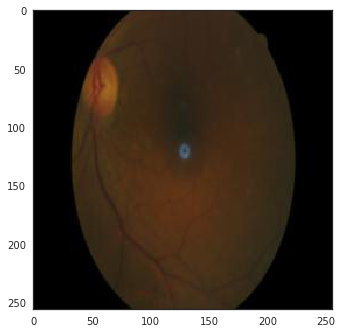

In [23]:
plt.imshow(df_image['actual_image'][0])

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


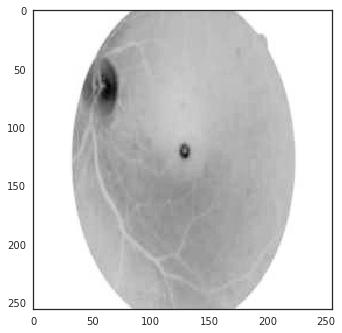

In [24]:
plt.imshow(df_image['image_resize'][0])

In [25]:
train_df = pd.merge(df_image, df_labels, on='image', how='inner')

In [26]:
train_df.head()

,image,actual_image,image_resize,level,location
0,32734_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,left
1,19288_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,right
2,23004_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,left
3,17586_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,left
4,19444_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,right


In [27]:
len(train_df), len(df_image), len(df_labels)

(28530, 28530, 35126)

# Work on Test Images

In [28]:
testlabelpath = '/home/aremirata/thesis/kaggle/retinopathy_solution.csv'
test_labels = pd.read_csv(testlabelpath)

In [29]:
test_labels.head()

,image,level,Usage
0,1_left,0,Private
1,1_right,0,Private
2,2_left,0,Public
3,2_right,0,Public
4,3_left,2,Private


In [30]:
resize_test_images = glob.glob('/home/aremirata/thesis/kaggle/test_resize/*')

In [31]:
index = range(0, len(resize_test_images))
df_test_image = pd.DataFrame(index=index, columns=['image','actual_image'])
for i in range(len(resize_test_images)):
    df_test_image['image'][i] = resize_test_images[i].split('/')[-1][0:-5]
    df_test_image['actual_image'][i] = misc.imread(resize_test_images[i])

In [32]:
df_test_image.head()

,image,actual_image
0,42474_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,29687_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,38632_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,24481_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,28742_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [33]:
df_test_image['image_resize'] = df_test_image['actual_image'].apply(lambda x: color.rgb2gray(x))

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


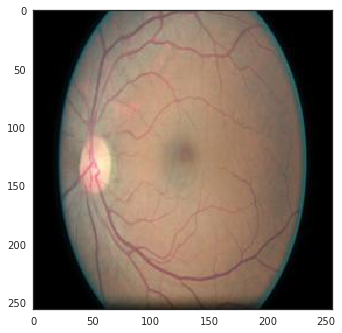

In [34]:
plt.imshow(df_test_image['actual_image'][0])

/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


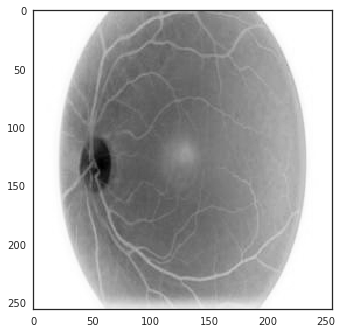

In [35]:
plt.imshow(df_test_image['image_resize'][0])

In [36]:
test_df = pd.merge(df_test_image, test_labels, on='image', how='inner')

In [37]:
test_df.head()

,image,actual_image,image_resize,level,Usage
0,42474_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
1,29687_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
2,38632_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
3,24481_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,Private
4,28742_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,Public


# Apply Compressed NMF to Training Set

In [38]:
train_df['image_flatten'] = train_df['image_resize'].apply(lambda x: x.ravel())

In [39]:
train_df.head()

,image,actual_image,image_resize,level,location,image_flatten
0,32734_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,left,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,19288_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,right,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,23004_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,left,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,17586_left,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,left,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,19444_right,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,right,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [40]:
training_set = np.stack(train_df['image_flatten'].as_matrix(),axis=0)

In [41]:
training_set

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [42]:
training_set.shape

(28530, 65536)

## Check Sparsity of Training Data

In [43]:
sparsity_value =  np.count_nonzero(training_set)/np.prod(training_set.shape)

In [44]:
sparsity_value

0.71280474684508355

The data above can be considered as nonsparse since there are more nonzero entries.

# Uncompressed NMF

In [45]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf

In [46]:
%time W, H, n_iters, rel_errors = nmf(training_set, n_components=10, max_iter=30, random_state=42)

CPU times: user 1h 25min 9s, sys: 24min 9s, total: 1h 49min 18s
Wall time: 26min 6s


/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


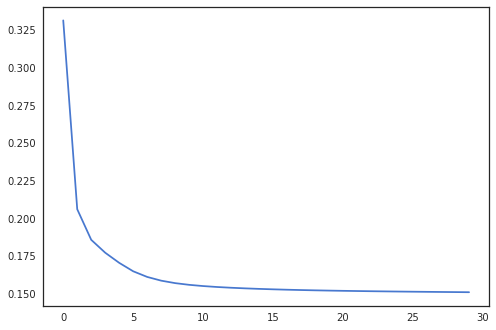

In [47]:
plt.plot(rel_errors)

### Compressed NMF with Algo 42

In [48]:
%%time
U, V, relative_error = structured_randomized_bppnmf(training_set, algo='algo42', q=10, r=10, max_iter = 30, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method
CPU times: user 29d 17h 37min 15s, sys: 3d 9h 44min 37s, total: 33d 3h 21min 52s
Wall time: 2d 19min 20s


/home/aremirata/anaconda3/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


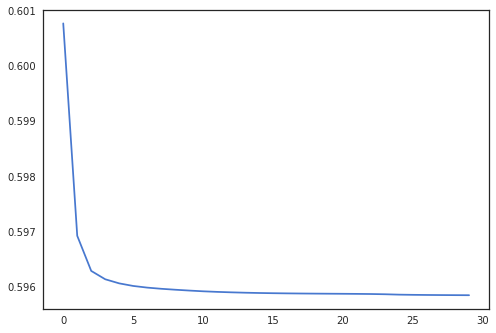

In [49]:
plt.plot(relative_error)

### Compressed NMF with QR

In [ ]:
%%time
U, V, relative_error_qr = structured_randomized_bppnmf(training_set, q=10, r=10, max_iter = 30, eps = 0.00001, oversampling = 20, 
                     oversampling_factor = 20, random_state=2)

The matrix is dense. We use compressed block principal pivoting method


In [ ]:
plt.plot(relative_error_qr)